# Setup #

Latex Definitions of Bra, Ket


In [13]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

import os
import math

# Detection algorithm works with an NxN matrix
N = 8
#N is a power of 2

# Helper Functions #

In [22]:
def plot_image(img, title = ""):
    plt.title(title)
    
    if img.shape[0] <= 32:
        plt.xticks(range(img.shape[0]))
        plt.yticks(range(img.shape[1]))
    
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

In [15]:
#Normalize -- squared amplitudes must sum to 1
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

In [32]:
def getPath(folder, file):
    return os.path.join("test_images", "small2.png")

# Image Preprocessing #

In [33]:
#Input Processing to np array

img_raw = plt.imread(getPath("test_images", "small2.png"))
# img_raw = plt.imread('/test_images/test_image1.jpg')

n, m, k = img_raw.shape
print('Raw Image info:', img_raw.shape)
print('Raw Image datatype:', img_raw.dtype)

if n != m:
    raise Exception("Image must be square")

if n % N != 0:
    raise Exception(f"Image cannot be converted to an {N} by {N} matrix")

# we need to "reduce" each sz X sz grid
sz = n // N

Raw Image info: (8, 8, 4)
Raw Image datatype: float32


Original Image:


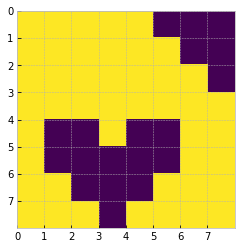

Processed Image:


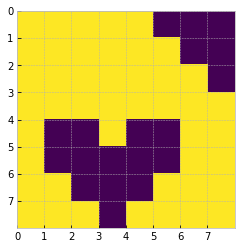

In [24]:
img = np.zeros(shape=(N, N))

for i in range(0, n, sz):
    for j in range(0, n, sz):
        val = 0
        #This will be a single cell in final pixel
        for k in range(0, sz):
            val += np.sum(img_raw[i + k][j:j+sz][0]) / 255
#             val += np.sum(img_raw[i + k][j:j+sz][1]) / 255
#             val += np.sum(img_raw[i + k][j:j+sz][2]) / 255
            
        img[i//sz][j//sz] = val

print("Original Image:")
plot_image(img)
print("Processed Image:")
plot_image(img)

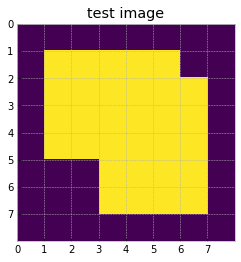

In [25]:
# testing image
img = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

plot_image(img, "test image")

In [26]:
# Horizontal: Original image
image_norm_h = amplitude_encode(img)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(img.T)

# Quantum Part #

## Quantum Probability Image Encoding (QPIE) ##

### Based on [Paper](https://arxiv.org/pdf/2012.11036.pdf) ###

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

Basic idea:

Recall each element in our processed image grid represents the color intensity in that cell.

Let's assign $c = grid[i][j]$, and index of $c$ as $i * N + j$.

In QPIE representation, the image becomes 

$\ket{\text{Img}} = \sum _{i=0} ^{2^n-1} c_i \ket{i}$ or $\ket{\text{Img}} = \sum _{i=0} ^{2^n-1} grid[\frac{i}{N}][i \mod N] \ket{i}$ (n is number of qubits)

This means that we need $n = \lceil \log_2N^2 \rceil$ qubits in order to index all $N^2$ pixels in our image.

In order to actually achieve the desired amplitudes ($c$) for all quantum states states, we can use a combination of CNOT and Aritrary Rotation Gates.

For example, to encode (0, 128, 192, 255):

![quantum state preparation](https://qiskit.org/textbook/ch-applications/images/state_prep.png)
^Replace this with github link to our repo's explanation diagram

Quiskit has a nice implementation of this algorithm for us [here](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.initialize.html), which we can call through .initialize on the QuantumCircuit.

In [27]:
# qubit amount
# data_qb should be math.ceil(math.log2(number of pixels))
data_qb = math.ceil(math.log2(N**2))
anc_qb = 1
total_qb = data_qb + anc_qb

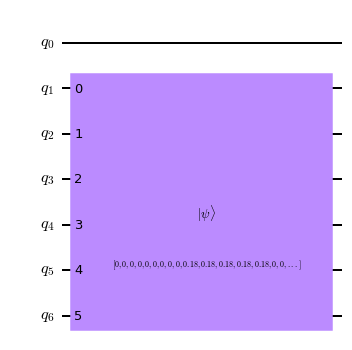

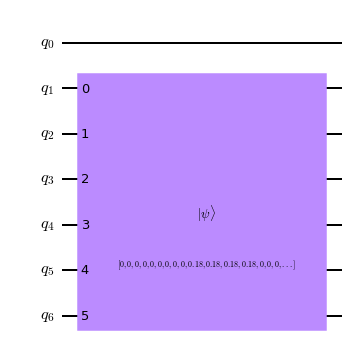

In [36]:
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
display(qc_h.draw('mpl', fold=-1))

qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
display(qc_v.draw('mpl', fold=-1))

## Quantum Hadamard Edge Detection (QHED) ##

### Based on [Paper](https://arxiv.org/abs/1801.01465) ###

$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$

The are 2 parts to this algorithm.

The first is a simple Hadamard Gate on qubit 0, which is the least significant bit (LSB) in our indexing and highlighted in red below:

Index 0: $00\color{red}{0}$

Index 1: $00\color{red}{1}$

Index 2: $01\color{red}{0}$

Index 3: $01\color{red}{1}$

Index 4: $10\color{red}{0}$

Index 5: $10\color{red}{1}$

$. . .$

Notice how it alternates, which makes sense when we consider $mod 2$. This property works neatly with a Hadamard Gate. Recall the definition of a Hamadard Gate:

$
|0 \rangle \rightarrow \frac{(|0 \rangle + |1 \rangle)}{\sqrt{2}} \\
|1 \rangle \rightarrow \frac{(|0 \rangle - |1 \rangle)}{\sqrt{2}}
$

Peforming this action on Index 0 yields:

$|0 \rangle \rightarrow \frac{(|0 \rangle + |1 \rangle)}{\sqrt{2}}$

Quiskit also allows us to directly apply matrix transformations to quantum states. 

https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.unitary.html

$
D_{2^{n+1}} =
\begin{bmatrix}
0 & 1 & 0 & 0 & \dots & 0 & 0 \\
0 & 0 & 1 & 0 & \dots & 0 & 0 \\
0 & 0 & 0 & 1 & \dots & 0 & 0 \\
0 & 0 & 0 & 0 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \dots & 0 & 1 \\
1 & 0 & 0 & 0 & \dots & 0 & 0 \\
\end{bmatrix}
$

In [ ]:
# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

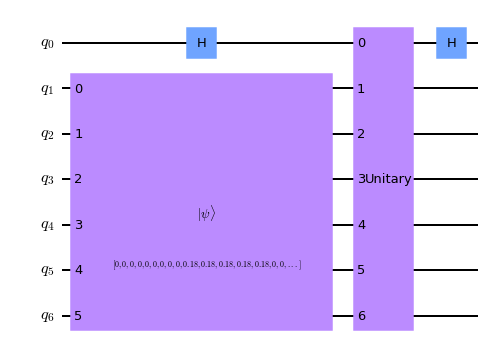

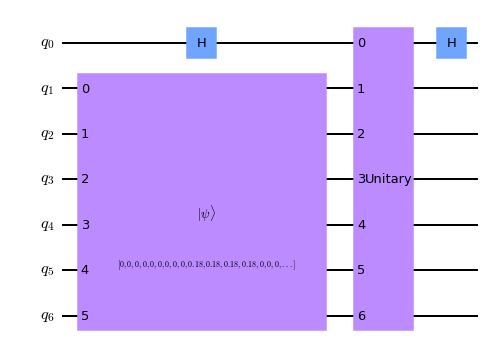

In [28]:
# horizontal scan circuit


#Qiskit offers this super nice implementation for us
#https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.initialize.html
#Sets the amplitudes to desired pixel values that is in image
#We can accomplish the same effect with Arbitrary rotation gates a CNOTs

qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# vertical scan circuit

qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits
circ_list = [qc_h, qc_v]

In [29]:
# run simulator
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

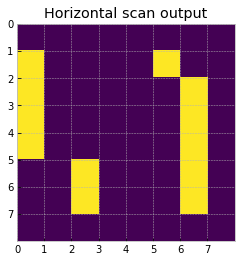

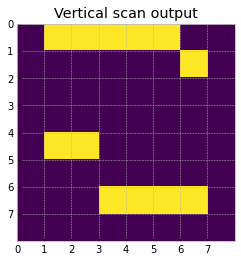

In [30]:
# Classical postprocessing and plotting

# lambda function for binary value thresholding
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# select odd states from raw statevectors and 
# reshape column vector to NxN
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(N, N)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(N, N).T

# plotting horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

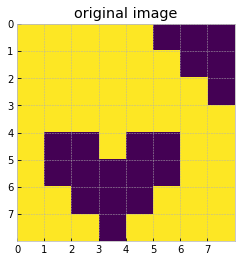

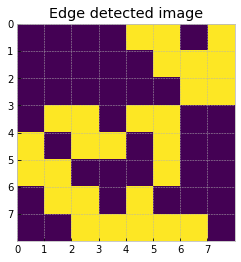

In [19]:
# combining horizontal and vertical
#Bitwise 
edge_scan_sim = edge_scan_h | edge_scan_v

# plot original and edge detected images
plot_image(img, 'original image')
plot_image(edge_scan_sim, 'Edge detected image')